walmart 주단위 데이터 139주로 향후 4주 예측하기

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
# tf.set_random_seed(77)
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac12.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [24]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [25]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [26]:
def LSTM(txs, forecastDay, features):

    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 5
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 50
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001
    # iterations는 반복 횟수
    iterations = 5000

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
 
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(i, step_loss))
       

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY,originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
#         plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict), realSale




[[  8.73233863e-05   3.49293545e-05   0.00000000e+00   3.51040013e-02
    4.35298348e-01]
 [  1.04788064e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    8.04064834e-01]
 [  1.22252741e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    7.26452856e-01]
 [  1.39717418e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    3.38876564e-01]
 [  1.57182095e-04   5.23940318e-05   1.74646773e-05   3.51040013e-02
    3.81217229e-01]] -> [ 0.36751601]
[[  1.04788064e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    8.04064834e-01]
 [  1.22252741e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    7.26452856e-01]
 [  1.39717418e-04   3.49293545e-05   0.00000000e+00   3.51040013e-02
    3.38876564e-01]
 [  1.57182095e-04   5.23940318e-05   1.74646773e-05   3.51040013e-02
    3.81217229e-01]
 [  1.74646773e-04   5.23940318e-05   1.74646773e-05   3.51040013e-02
    3.67516015e-01]] -> [ 0.38660927]
[[  1.22252741e-04   3.49293545e-05   0.00000000e+00   3.5104001

    5.50096291e-01]] -> [ 0.7843886]
[[  8.03375154e-04   1.92111450e-04   5.23940318e-05   3.51040013e-02
    3.41484040e-01]
 [  8.20839831e-04   1.92111450e-04   5.23940318e-05   3.51040013e-02
    3.28690291e-01]
 [  8.38304508e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    3.93261918e-01]
 [  8.55769185e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    5.50096291e-01]
 [  8.73233863e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    7.84388604e-01]] -> [ 0.97682088]
[[  8.20839831e-04   1.92111450e-04   5.23940318e-05   3.51040013e-02
    3.28690291e-01]
 [  8.38304508e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    3.93261918e-01]
 [  8.55769185e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    5.50096291e-01]
 [  8.73233863e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    7.84388604e-01]
 [  8.90698540e-04   2.09576127e-04   0.00000000e+00   3.51040013e-02
    9.76820880e-01]] -> [ 0.33400462]
[[  8.38304508e-04   2.0957

[step: 28] loss: 3.516055107116699
[step: 29] loss: 3.5246710777282715
[step: 30] loss: 3.495209217071533
[step: 31] loss: 3.4359798431396484
[step: 32] loss: 3.357630729675293
[step: 33] loss: 3.2709341049194336
[step: 34] loss: 3.1852433681488037
[step: 35] loss: 3.107642650604248
[step: 36] loss: 3.0426833629608154
[step: 37] loss: 2.9925336837768555
[step: 38] loss: 2.9573869705200195
[step: 39] loss: 2.935976028442383
[step: 40] loss: 2.926098108291626
[step: 41] loss: 2.925079345703125
[step: 42] loss: 2.9301462173461914
[step: 43] loss: 2.93869686126709
[step: 44] loss: 2.948477029800415
[step: 45] loss: 2.9576756954193115
[step: 46] loss: 2.964960813522339
[step: 47] loss: 2.9694676399230957
[step: 48] loss: 2.9707605838775635
[step: 49] loss: 2.968773365020752
[step: 50] loss: 2.963740348815918
[step: 51] loss: 2.956122636795044
[step: 52] loss: 2.9465341567993164
[step: 53] loss: 2.935671806335449
[step: 54] loss: 2.9242489337921143
[step: 55] loss: 2.912938356399536
[step: 5

[step: 274] loss: 2.453494071960449
[step: 275] loss: 2.451371192932129
[step: 276] loss: 2.44924259185791
[step: 277] loss: 2.4471077919006348
[step: 278] loss: 2.4449679851531982
[step: 279] loss: 2.4428224563598633
[step: 280] loss: 2.44067120552063
[step: 281] loss: 2.438514232635498
[step: 282] loss: 2.4363512992858887
[step: 283] loss: 2.434183359146118
[step: 284] loss: 2.432009220123291
[step: 285] loss: 2.4298295974731445
[step: 286] loss: 2.4276437759399414
[step: 287] loss: 2.425452709197998
[step: 288] loss: 2.423255681991577
[step: 289] loss: 2.4210526943206787
[step: 290] loss: 2.418844223022461
[step: 291] loss: 2.4166297912597656
[step: 292] loss: 2.414409875869751
[step: 293] loss: 2.412184238433838
[step: 294] loss: 2.4099531173706055
[step: 295] loss: 2.4077160358428955
[step: 296] loss: 2.405473232269287
[step: 297] loss: 2.403224468231201
[step: 298] loss: 2.400970458984375
[step: 299] loss: 2.3987112045288086
[step: 300] loss: 2.3964457511901855
[step: 301] loss: 

[step: 498] loss: 1.9035794734954834
[step: 499] loss: 1.9006195068359375
[step: 500] loss: 1.8976597785949707
[step: 501] loss: 1.894700050354004
[step: 502] loss: 1.8917410373687744
[step: 503] loss: 1.8887827396392822
[step: 504] loss: 1.885825276374817
[step: 505] loss: 1.8828693628311157
[step: 506] loss: 1.8799147605895996
[step: 507] loss: 1.876962423324585
[step: 508] loss: 1.8740119934082031
[step: 509] loss: 1.8710639476776123
[step: 510] loss: 1.868118405342102
[step: 511] loss: 1.8651762008666992
[step: 512] loss: 1.8622368574142456
[step: 513] loss: 1.8593010902404785
[step: 514] loss: 1.8563690185546875
[step: 515] loss: 1.8534414768218994
[step: 516] loss: 1.850517749786377
[step: 517] loss: 1.8475987911224365
[step: 518] loss: 1.8446847200393677
[step: 519] loss: 1.8417754173278809
[step: 520] loss: 1.8388718366622925
[step: 521] loss: 1.8359737396240234
[step: 522] loss: 1.8330813646316528
[step: 523] loss: 1.830195426940918
[step: 524] loss: 1.8273155689239502
[step: 

[step: 726] loss: 1.4874416589736938
[step: 727] loss: 1.4862141609191895
[step: 728] loss: 1.4849853515625
[step: 729] loss: 1.4837543964385986
[step: 730] loss: 1.4825211763381958
[step: 731] loss: 1.4812861680984497
[step: 732] loss: 1.4800487756729126
[step: 733] loss: 1.478808879852295
[step: 734] loss: 1.477567434310913
[step: 735] loss: 1.476322889328003
[step: 736] loss: 1.4750761985778809
[step: 737] loss: 1.47382652759552
[step: 738] loss: 1.4725745916366577
[step: 739] loss: 1.4713201522827148
[step: 740] loss: 1.4700627326965332
[step: 741] loss: 1.4688019752502441
[step: 742] loss: 1.4675381183624268
[step: 743] loss: 1.4662714004516602
[step: 744] loss: 1.4650019407272339
[step: 745] loss: 1.463728904724121
[step: 746] loss: 1.4624520540237427
[step: 747] loss: 1.4611718654632568
[step: 748] loss: 1.459888219833374
[step: 749] loss: 1.4586011171340942
[step: 750] loss: 1.4573099613189697
[step: 751] loss: 1.4560147523880005
[step: 752] loss: 1.4547152519226074
[step: 753]

[step: 975] loss: 0.942743182182312
[step: 976] loss: 0.94010329246521
[step: 977] loss: 0.9382714033126831
[step: 978] loss: 0.9376769065856934
[step: 979] loss: 0.9360369443893433
[step: 980] loss: 0.9338064193725586
[step: 981] loss: 0.9326558709144592
[step: 982] loss: 0.9317359924316406
[step: 983] loss: 0.9299378395080566
[step: 984] loss: 0.9281895756721497
[step: 985] loss: 0.9271885752677917
[step: 986] loss: 0.9260748624801636
[step: 987] loss: 0.9244130253791809
[step: 988] loss: 0.9229297637939453
[step: 989] loss: 0.9219143390655518
[step: 990] loss: 0.9207836985588074
[step: 991] loss: 0.9193106293678284
[step: 992] loss: 0.917942464351654
[step: 993] loss: 0.9168891906738281
[step: 994] loss: 0.9158235788345337
[step: 995] loss: 0.9145321249961853
[step: 996] loss: 0.9132301807403564
[step: 997] loss: 0.9121298789978027
[step: 998] loss: 0.9111204743385315
[step: 999] loss: 0.9100029468536377
[step: 1000] loss: 0.9087965488433838
[step: 1001] loss: 0.9076590538024902
[st

[step: 1198] loss: 0.7956525683403015
[step: 1199] loss: 0.8009317517280579
[step: 1200] loss: 0.8004135489463806
[step: 1201] loss: 0.794452428817749
[step: 1202] loss: 0.7915626764297485
[step: 1203] loss: 0.7944263815879822
[step: 1204] loss: 0.7962478399276733
[step: 1205] loss: 0.7929859757423401
[step: 1206] loss: 0.7898433208465576
[step: 1207] loss: 0.7909303903579712
[step: 1208] loss: 0.7925117015838623
[step: 1209] loss: 0.7907559871673584
[step: 1210] loss: 0.7882549166679382
[step: 1211] loss: 0.7885112762451172
[step: 1212] loss: 0.7895941734313965
[step: 1213] loss: 0.7884927988052368
[step: 1214] loss: 0.7866191864013672
[step: 1215] loss: 0.7864835262298584
[step: 1216] loss: 0.7871063947677612
[step: 1217] loss: 0.7863931059837341
[step: 1218] loss: 0.7849750518798828
[step: 1219] loss: 0.7846218943595886
[step: 1220] loss: 0.7849221229553223
[step: 1221] loss: 0.784419596195221
[step: 1222] loss: 0.7833342552185059
[step: 1223] loss: 0.7828474044799805
[step: 1224] l

[step: 1415] loss: 0.7040961384773254
[step: 1416] loss: 0.7037073373794556
[step: 1417] loss: 0.7033221125602722
[step: 1418] loss: 0.7029337882995605
[step: 1419] loss: 0.7025414109230042
[step: 1420] loss: 0.7021474838256836
[step: 1421] loss: 0.7017552852630615
[step: 1422] loss: 0.7013676166534424
[step: 1423] loss: 0.7009819746017456
[step: 1424] loss: 0.70059734582901
[step: 1425] loss: 0.7002103328704834
[step: 1426] loss: 0.6998223066329956
[step: 1427] loss: 0.6994338035583496
[step: 1428] loss: 0.6990479230880737
[step: 1429] loss: 0.6986646056175232
[step: 1430] loss: 0.6982821822166443
[step: 1431] loss: 0.6979002952575684
[step: 1432] loss: 0.6975181102752686
[step: 1433] loss: 0.697135329246521
[step: 1434] loss: 0.6967534422874451
[step: 1435] loss: 0.6963728070259094
[step: 1436] loss: 0.695993185043335
[step: 1437] loss: 0.6956149935722351
[step: 1438] loss: 0.6952379941940308
[step: 1439] loss: 0.6948606967926025
[step: 1440] loss: 0.6944847106933594
[step: 1441] los

[step: 1631] loss: 0.6403472423553467
[step: 1632] loss: 0.6400931477546692
[step: 1633] loss: 0.6398389339447021
[step: 1634] loss: 0.6395837068557739
[step: 1635] loss: 0.6393285989761353
[step: 1636] loss: 0.6390729546546936
[step: 1637] loss: 0.6388168931007385
[step: 1638] loss: 0.6385596394538879
[step: 1639] loss: 0.6383025646209717
[step: 1640] loss: 0.6380449533462524
[step: 1641] loss: 0.6377869844436646
[step: 1642] loss: 0.6375284194946289
[step: 1643] loss: 0.6372691988945007
[step: 1644] loss: 0.6370092034339905
[step: 1645] loss: 0.636749267578125
[step: 1646] loss: 0.6364879012107849
[step: 1647] loss: 0.6362276077270508
[step: 1648] loss: 0.6359659433364868
[step: 1649] loss: 0.6357032060623169
[step: 1650] loss: 0.6354405283927917
[step: 1651] loss: 0.6351765394210815
[step: 1652] loss: 0.6349126100540161
[step: 1653] loss: 0.6346484422683716
[step: 1654] loss: 0.634382963180542
[step: 1655] loss: 0.6341169476509094
[step: 1656] loss: 0.6338506937026978
[step: 1657] l

[step: 1849] loss: 0.5683013796806335
[step: 1850] loss: 0.5678799748420715
[step: 1851] loss: 0.5674588680267334
[step: 1852] loss: 0.5670363306999207
[step: 1853] loss: 0.566612958908081
[step: 1854] loss: 0.566189169883728
[step: 1855] loss: 0.565765380859375
[step: 1856] loss: 0.5653402805328369
[step: 1857] loss: 0.5649148225784302
[step: 1858] loss: 0.5644888281822205
[step: 1859] loss: 0.5640619993209839
[step: 1860] loss: 0.5636351108551025
[step: 1861] loss: 0.5632073879241943
[step: 1862] loss: 0.562778651714325
[step: 1863] loss: 0.5623498558998108
[step: 1864] loss: 0.561920166015625
[step: 1865] loss: 0.5614907145500183
[step: 1866] loss: 0.5610597729682922
[step: 1867] loss: 0.56062912940979
[step: 1868] loss: 0.5601973533630371
[step: 1869] loss: 0.5597649216651917
[step: 1870] loss: 0.5593324899673462
[step: 1871] loss: 0.5588998794555664
[step: 1872] loss: 0.558465838432312
[step: 1873] loss: 0.5580319166183472
[step: 1874] loss: 0.5575973987579346
[step: 1875] loss: 0

[step: 2065] loss: 0.469356507062912
[step: 2066] loss: 0.4687976837158203
[step: 2067] loss: 0.46823668479919434
[step: 2068] loss: 0.46767377853393555
[step: 2069] loss: 0.4671088755130768
[step: 2070] loss: 0.4665428102016449
[step: 2071] loss: 0.4659745693206787
[step: 2072] loss: 0.4654051661491394
[step: 2073] loss: 0.4648336172103882
[step: 2074] loss: 0.46426036953926086
[step: 2075] loss: 0.4636850953102112
[step: 2076] loss: 0.4631084203720093
[step: 2077] loss: 0.46252965927124023
[step: 2078] loss: 0.4619491994380951
[step: 2079] loss: 0.4613667130470276
[step: 2080] loss: 0.4607824683189392
[step: 2081] loss: 0.4601965546607971
[step: 2082] loss: 0.4596092402935028
[step: 2083] loss: 0.459019273519516
[step: 2084] loss: 0.4584282636642456
[step: 2085] loss: 0.4578346610069275
[step: 2086] loss: 0.45723971724510193
[step: 2087] loss: 0.4566425681114197
[step: 2088] loss: 0.4560432434082031
[step: 2089] loss: 0.45544305443763733
[step: 2090] loss: 0.45483946800231934
[step: 

[step: 2302] loss: 0.3223589062690735
[step: 2303] loss: 0.32185137271881104
[step: 2304] loss: 0.3212162256240845
[step: 2305] loss: 0.3206029534339905
[step: 2306] loss: 0.32010364532470703
[step: 2307] loss: 0.3196496367454529
[step: 2308] loss: 0.3191307485103607
[step: 2309] loss: 0.31854021549224854
[step: 2310] loss: 0.3179621696472168
[step: 2311] loss: 0.317448228597641
[step: 2312] loss: 0.3169681429862976
[step: 2313] loss: 0.3164569139480591
[step: 2314] loss: 0.315901517868042
[step: 2315] loss: 0.31534165143966675
[step: 2316] loss: 0.31481462717056274
[step: 2317] loss: 0.31431639194488525
[step: 2318] loss: 0.31381291151046753
[step: 2319] loss: 0.3132842779159546
[step: 2320] loss: 0.31274113059043884
[step: 2321] loss: 0.3122076988220215
[step: 2322] loss: 0.31169354915618896
[step: 2323] loss: 0.31118935346603394
[step: 2324] loss: 0.3106783330440521
[step: 2325] loss: 0.31015467643737793
[step: 2326] loss: 0.30962538719177246
[step: 2327] loss: 0.30910199880599976
[

[step: 2534] loss: 0.22615227103233337
[step: 2535] loss: 0.22629237174987793
[step: 2536] loss: 0.22686690092086792
[step: 2537] loss: 0.2282804250717163
[step: 2538] loss: 0.23104889690876007
[step: 2539] loss: 0.23584292829036713
[step: 2540] loss: 0.24161499738693237
[step: 2541] loss: 0.24571025371551514
[step: 2542] loss: 0.24190036952495575
[step: 2543] loss: 0.23196172714233398
[step: 2544] loss: 0.22356638312339783
[step: 2545] loss: 0.22386790812015533
[step: 2546] loss: 0.22976206243038177
[step: 2547] loss: 0.23226773738861084
[step: 2548] loss: 0.22782811522483826
[step: 2549] loss: 0.2218371331691742
[step: 2550] loss: 0.2215876579284668
[step: 2551] loss: 0.22535312175750732
[step: 2552] loss: 0.22619223594665527
[step: 2553] loss: 0.22268027067184448
[step: 2554] loss: 0.21964703500270844
[step: 2555] loss: 0.22049587965011597
[step: 2556] loss: 0.22250181436538696
[step: 2557] loss: 0.22180360555648804
[step: 2558] loss: 0.2192051112651825
[step: 2559] loss: 0.21810463

[step: 2749] loss: 0.17144893109798431
[step: 2750] loss: 0.1713077276945114
[step: 2751] loss: 0.17114874720573425
[step: 2752] loss: 0.17097587883472443
[step: 2753] loss: 0.17080453038215637
[step: 2754] loss: 0.1706453561782837
[step: 2755] loss: 0.1704963594675064
[step: 2756] loss: 0.170348659157753
[step: 2757] loss: 0.17019440233707428
[step: 2758] loss: 0.17003335058689117
[step: 2759] loss: 0.16987058520317078
[step: 2760] loss: 0.16971302032470703
[step: 2761] loss: 0.1695629209280014
[step: 2762] loss: 0.1694156527519226
[step: 2763] loss: 0.1692657768726349
[step: 2764] loss: 0.16911156475543976
[step: 2765] loss: 0.16895529627799988
[step: 2766] loss: 0.16880100965499878
[step: 2767] loss: 0.16865074634552002
[step: 2768] loss: 0.16850337386131287
[step: 2769] loss: 0.1683557629585266
[step: 2770] loss: 0.1682078242301941
[step: 2771] loss: 0.16805794835090637
[step: 2772] loss: 0.1679076850414276
[step: 2773] loss: 0.1677587330341339
[step: 2774] loss: 0.1676109731197357

[step: 2981] loss: 0.14416863024234772
[step: 2982] loss: 0.14407587051391602
[step: 2983] loss: 0.1439870446920395
[step: 2984] loss: 0.14390501379966736
[step: 2985] loss: 0.14383742213249207
[step: 2986] loss: 0.14379635453224182
[step: 2987] loss: 0.14380860328674316
[step: 2988] loss: 0.143927663564682
[step: 2989] loss: 0.1442575603723526
[step: 2990] loss: 0.14501850306987762
[step: 2991] loss: 0.14661440253257751
[step: 2992] loss: 0.14985935389995575
[step: 2993] loss: 0.15587207674980164
[step: 2994] loss: 0.1661786437034607
[step: 2995] loss: 0.17900000512599945
[step: 2996] loss: 0.18825113773345947
[step: 2997] loss: 0.17975935339927673
[step: 2998] loss: 0.15800324082374573
[step: 2999] loss: 0.1438138782978058
[step: 3000] loss: 0.15036657452583313
[step: 3001] loss: 0.16279292106628418
[step: 3002] loss: 0.1606244593858719
[step: 3003] loss: 0.14824005961418152
[step: 3004] loss: 0.14423827826976776
[step: 3005] loss: 0.15112853050231934
[step: 3006] loss: 0.15385560691

[step: 3212] loss: 0.1272699236869812
[step: 3213] loss: 0.12933538854122162
[step: 3214] loss: 0.1334960013628006
[step: 3215] loss: 0.14117009937763214
[step: 3216] loss: 0.15400728583335876
[step: 3217] loss: 0.16941064596176147
[step: 3218] loss: 0.17848750948905945
[step: 3219] loss: 0.16605249047279358
[step: 3220] loss: 0.13981139659881592
[step: 3221] loss: 0.12645648419857025
[step: 3222] loss: 0.13657709956169128
[step: 3223] loss: 0.14945131540298462
[step: 3224] loss: 0.14429131150245667
[step: 3225] loss: 0.13034740090370178
[step: 3226] loss: 0.12840183079242706
[step: 3227] loss: 0.13630345463752747
[step: 3228] loss: 0.13714003562927246
[step: 3229] loss: 0.1298636496067047
[step: 3230] loss: 0.12723787128925323
[step: 3231] loss: 0.13064076006412506
[step: 3232] loss: 0.13102076947689056
[step: 3233] loss: 0.12789946794509888
[step: 3234] loss: 0.12675534188747406
[step: 3235] loss: 0.1275542974472046
[step: 3236] loss: 0.12740206718444824
[step: 3237] loss: 0.12652352

[step: 3446] loss: 0.1316029280424118
[step: 3447] loss: 0.11341086030006409
[step: 3448] loss: 0.11671199649572372
[step: 3449] loss: 0.12871313095092773
[step: 3450] loss: 0.13050535321235657
[step: 3451] loss: 0.12070943415164948
[step: 3452] loss: 0.1145201027393341
[step: 3453] loss: 0.11699294298887253
[step: 3454] loss: 0.11951886862516403
[step: 3455] loss: 0.11826644837856293
[step: 3456] loss: 0.11603598296642303
[step: 3457] loss: 0.11382468789815903
[step: 3458] loss: 0.11240970343351364
[step: 3459] loss: 0.11408174782991409
[step: 3460] loss: 0.11503937095403671
[step: 3461] loss: 0.1118273213505745
[step: 3462] loss: 0.10932944715023041
[step: 3463] loss: 0.1117386519908905
[step: 3464] loss: 0.11339083313941956
[step: 3465] loss: 0.11001421511173248
[step: 3466] loss: 0.10808280110359192
[step: 3467] loss: 0.11070731282234192
[step: 3468] loss: 0.11132105439901352
[step: 3469] loss: 0.10852941125631332
[step: 3470] loss: 0.1080622673034668
[step: 3471] loss: 0.109797619

[step: 3675] loss: 0.09952906519174576
[step: 3676] loss: 0.10281901806592941
[step: 3677] loss: 0.10209129750728607
[step: 3678] loss: 0.09841202199459076
[step: 3679] loss: 0.09610218554735184
[step: 3680] loss: 0.09794405102729797
[step: 3681] loss: 0.10061605274677277
[step: 3682] loss: 0.1002124473452568
[step: 3683] loss: 0.09775963425636292
[step: 3684] loss: 0.09595029801130295
[step: 3685] loss: 0.09688256680965424
[step: 3686] loss: 0.09872666001319885
[step: 3687] loss: 0.0986805409193039
[step: 3688] loss: 0.09704461693763733
[step: 3689] loss: 0.09567906707525253
[step: 3690] loss: 0.09610395133495331
[step: 3691] loss: 0.09735462069511414
[step: 3692] loss: 0.09740087389945984
[step: 3693] loss: 0.09640178084373474
[step: 3694] loss: 0.09547866135835648
[step: 3695] loss: 0.09555104374885559
[step: 3696] loss: 0.09634611010551453
[step: 3697] loss: 0.0965077355504036
[step: 3698] loss: 0.09589074552059174
[step: 3699] loss: 0.09525618702173233
[step: 3700] loss: 0.0951358

[step: 3905] loss: 0.08517247438430786
[step: 3906] loss: 0.08512528240680695
[step: 3907] loss: 0.08507687598466873
[step: 3908] loss: 0.08502821624279022
[step: 3909] loss: 0.08497927337884903
[step: 3910] loss: 0.08493049442768097
[step: 3911] loss: 0.08488226681947708
[step: 3912] loss: 0.0848342627286911
[step: 3913] loss: 0.08478662371635437
[step: 3914] loss: 0.0847393125295639
[step: 3915] loss: 0.08469218015670776
[step: 3916] loss: 0.08464574068784714
[step: 3917] loss: 0.08459911495447159
[step: 3918] loss: 0.08455298840999603
[step: 3919] loss: 0.08450664579868317
[step: 3920] loss: 0.08446062356233597
[step: 3921] loss: 0.08441472053527832
[step: 3922] loss: 0.08436885476112366
[step: 3923] loss: 0.0843229591846466
[step: 3924] loss: 0.08427734673023224
[step: 3925] loss: 0.08423178642988205
[step: 3926] loss: 0.08418633043766022
[step: 3927] loss: 0.08414136618375778
[step: 3928] loss: 0.08409658074378967
[step: 3929] loss: 0.08405283838510513
[step: 3930] loss: 0.0840099

[step: 4122] loss: 0.0765109658241272
[step: 4123] loss: 0.07640296220779419
[step: 4124] loss: 0.07629987597465515
[step: 4125] loss: 0.07624159008264542
[step: 4126] loss: 0.07622380554676056
[step: 4127] loss: 0.07621952891349792
[step: 4128] loss: 0.0761944055557251
[step: 4129] loss: 0.07614555954933167
[step: 4130] loss: 0.07609119266271591
[step: 4131] loss: 0.07604165375232697
[step: 4132] loss: 0.07600018382072449
[step: 4133] loss: 0.07595972716808319
[step: 4134] loss: 0.07591915875673294
[step: 4135] loss: 0.07588011026382446
[step: 4136] loss: 0.07584504783153534
[step: 4137] loss: 0.07581599056720734
[step: 4138] loss: 0.07578431069850922
[step: 4139] loss: 0.07574481517076492
[step: 4140] loss: 0.07569941878318787
[step: 4141] loss: 0.07565107941627502
[step: 4142] loss: 0.07560815662145615
[step: 4143] loss: 0.07557294517755508
[step: 4144] loss: 0.07554327696561813
[step: 4145] loss: 0.07551375031471252
[step: 4146] loss: 0.07547987252473831
[step: 4147] loss: 0.075441

[step: 4344] loss: 0.06924986094236374
[step: 4345] loss: 0.06926663964986801
[step: 4346] loss: 0.06927177309989929
[step: 4347] loss: 0.06926660984754562
[step: 4348] loss: 0.06924229115247726
[step: 4349] loss: 0.06920883059501648
[step: 4350] loss: 0.0691634938120842
[step: 4351] loss: 0.06911557912826538
[step: 4352] loss: 0.06906372308731079
[step: 4353] loss: 0.06901627779006958
[step: 4354] loss: 0.06897002458572388
[step: 4355] loss: 0.06892985105514526
[step: 4356] loss: 0.06889290362596512
[step: 4357] loss: 0.06886125355958939
[step: 4358] loss: 0.06883203983306885
[step: 4359] loss: 0.06880675256252289
[step: 4360] loss: 0.06878366321325302
[step: 4361] loss: 0.06876546889543533
[step: 4362] loss: 0.06875075399875641
[step: 4363] loss: 0.06874366104602814
[step: 4364] loss: 0.06874418258666992
[step: 4365] loss: 0.06875913590192795
[step: 4366] loss: 0.06878934800624847
[step: 4367] loss: 0.06884936988353729
[step: 4368] loss: 0.06893956661224365
[step: 4369] loss: 0.06909

[step: 4573] loss: 0.06352321058511734
[step: 4574] loss: 0.06350955367088318
[step: 4575] loss: 0.06349974125623703
[step: 4576] loss: 0.06349531561136246
[step: 4577] loss: 0.0634986013174057
[step: 4578] loss: 0.06351403146982193
[step: 4579] loss: 0.06354677677154541
[step: 4580] loss: 0.06360800564289093
[step: 4581] loss: 0.06370917707681656
[step: 4582] loss: 0.06388041377067566
[step: 4583] loss: 0.06414584815502167
[step: 4584] loss: 0.06458494812250137
[step: 4585] loss: 0.06524135917425156
[step: 4586] loss: 0.06632192432880402
[step: 4587] loss: 0.06785079836845398
[step: 4588] loss: 0.07030661404132843
[step: 4589] loss: 0.07336223870515823
[step: 4590] loss: 0.07779297232627869
[step: 4591] loss: 0.08165833353996277
[step: 4592] loss: 0.08549217879772186
[step: 4593] loss: 0.08499699831008911
[step: 4594] loss: 0.08152887970209122
[step: 4595] loss: 0.07406030595302582
[step: 4596] loss: 0.06725630164146423
[step: 4597] loss: 0.0634530633687973
[step: 4598] loss: 0.063750

[step: 4801] loss: 0.059192366898059845
[step: 4802] loss: 0.059175044298172
[step: 4803] loss: 0.0591580867767334
[step: 4804] loss: 0.05914140120148659
[step: 4805] loss: 0.05912535637617111
[step: 4806] loss: 0.059110209345817566
[step: 4807] loss: 0.05909616872668266
[step: 4808] loss: 0.05908413231372833
[step: 4809] loss: 0.059074610471725464
[step: 4810] loss: 0.0590696707367897
[step: 4811] loss: 0.059071168303489685
[step: 4812] loss: 0.05908270925283432
[step: 4813] loss: 0.05911082774400711
[step: 4814] loss: 0.05916385352611542
[step: 4815] loss: 0.0592593252658844
[step: 4816] loss: 0.059419941157102585
[step: 4817] loss: 0.059693627059459686
[step: 4818] loss: 0.06013764068484306
[step: 4819] loss: 0.060886915773153305
[step: 4820] loss: 0.062071364372968674
[step: 4821] loss: 0.06405025720596313
[step: 4822] loss: 0.06699776649475098
[step: 4823] loss: 0.07166612148284912
[step: 4824] loss: 0.07752031832933426
[step: 4825] loss: 0.08509151637554169
[step: 4826] loss: 0.0

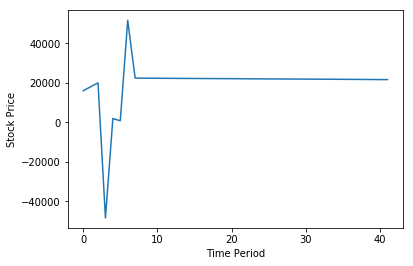

In [27]:
answer=LSTM(txs,1,'WeekNumber_Month_Season_Year' )

In [33]:
len(answer)

2

In [34]:
predict=answer[0]

In [35]:
real=answer[1]

In [36]:
predict

array([[ 15927.03710938],
       [ 17966.33203125],
       [ 19928.07617188],
       [-48421.41796875],
       [  1887.68847656],
       [   745.61981201],
       [ 51638.796875  ],
       [ 22342.67578125],
       [ 22314.609375  ],
       [ 22286.66601562],
       [ 22262.30664062],
       [ 22238.80859375],
       [ 22216.96484375],
       [ 22197.578125  ],
       [ 22177.24609375],
       [ 22158.73632812],
       [ 22140.56445312],
       [ 22118.75195312],
       [ 22098.390625  ],
       [ 22079.8828125 ],
       [ 22061.6796875 ],
       [ 22033.5625    ],
       [ 22005.5546875 ],
       [ 21981.08789062],
       [ 21957.53125   ],
       [ 21935.609375  ],
       [ 21916.17773438],
       [ 21895.78125   ],
       [ 21877.2265625 ],
       [ 21858.99609375],
       [ 21837.12304688],
       [ 21816.703125  ],
       [ 21798.12695312],
       [ 21779.88085938],
       [ 21761.50195312],
       [ 21735.74804688],
       [ 21707.61328125],
       [ 21683.09765625],
       [ 216

In [37]:
real

array([[ 16894.39999997],
       [ 18365.09999997],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [    

In [125]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [126]:
denormalizedTestPredictY

[15798.604,
 14722.048,
 15121.582,
 14954.279,
 17118.977,
 15644.573,
 15849.232,
 15525.247,
 14816.899,
 14112.375,
 14630.68,
 16013.2,
 17937.387,
 19444.676,
 19259.762,
 18787.432,
 24630.928,
 23599.018,
 24115.422,
 18142.271,
 61038.18,
 28532.447,
 15645.645,
 19705.068,
 21329.863,
 30300.719,
 40043.18,
 36211.652,
 22588.805]

In [ ]:
denormalizedTestY=originalSales[train_size+seq_length:]

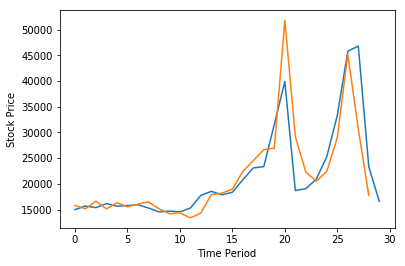

In [3]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [4]:
print(i for i in list(test_predict[-1]    ))

<generator object <genexpr> at 0x000000000CA1B1A8>


In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY